# Функции

In [1]:
library(tseries)
library(lubridate)

Generate_AR_2_ARCH_3 <- function(n, A, Teta) {
  E <- rnorm(n, 0, 1)
  x <- numeric(n)
  sqrtS <- numeric(n)

  x[1] <- sqrt(A[1]) * E[1]
  x[2] <- sqrt(A[1] + A[2] * x[1]^2) * E[2] + Teta[1] * x[1]

  for (i in 3:n) {
    sqrtS[i] <- sqrt(A[1] + A[2] * x[i - 1]^2 + A[3] * x[i - 2]^2)
    x[i] <- Teta[1] * x[i - 1] + Teta[2] * x[i - 2] + sqrtS[i] * E[i]
  }

  sqrtS[1] <- sqrt(A[1])
  sqrtS[2] <- sqrt(A[1] + A[2] * x[1]^2)

  for (i in 3:n) {
    sqrtS[i] <- sqrt(A[1] + A[2] * x[i - 1]^2 + A[3] * x[i - 2]^2)
  }

  return(list(x = x, sqrtS = sqrtS))
}

generate_forecast_plot <- function(test_data, theta, a) {
  n <- length(test_data)
  forecast_values <- numeric(n)
  forecast_sd_upper <- numeric(n) 
  forecast_sd_lower <- numeric(n)
  
  forecast_values[1:3] <- c(0, theta[1] * test_data[1], theta[1] * test_data[2] + theta[2] * test_data[1])
  forecast_sd_upper[1:3] <- c(a[1], a[1] + a[2] * test_data[1]^2, a[1] + a[2] * test_data[2]^2 + a[3] * test_data[1]^2)
  forecast_sd_lower[1:3] <- c(a[1], a[1] + a[2] * test_data[1]^2, a[1] + a[2] * test_data[2]^2 + a[3] * test_data[1]^2)
  
  for(i in 4:n) {
    forecast_values[i] <- theta[1] * test_data[i - 1] + theta[2] * test_data[i - 2]
    forecast_sd_upper[i] <- a[1] + a[2] * test_data[i - 1]^2 + a[3] * test_data[i - 2]^2 + a[4] * test_data[i - 3]^2
    forecast_sd_lower[i] <- a[1] + a[2] * test_data[i - 1]^2 + a[3] * test_data[i - 2]^2 + a[4] * test_data[i - 3]^2
  }
  
  for(i in 1:n) {
    forecast_sd_upper[i] <- forecast_values[i] + sqrt(forecast_sd_upper[i])
    forecast_sd_lower[i] <- forecast_values[i] - sqrt(forecast_sd_lower[i])
  }

  plot(test_data, type = 'l', col = 'blue')
  lines(forecast_values, type = 'p', col = 'black') 
  lines(forecast_sd_upper, col = 'red')
  lines(forecast_sd_lower, col = 'red')
}

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# 𝐴𝑅(2)𝐴𝑅𝐶𝐻(3)

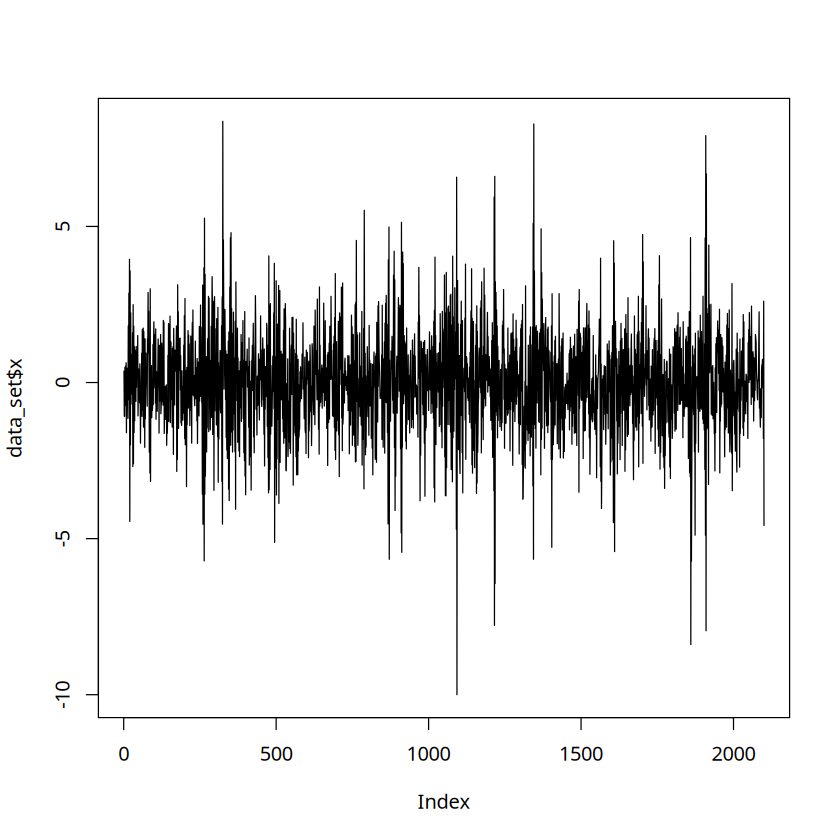

In [2]:
# set.seed(123)
n <- 2100
teta <- c(-.3, .4)
A <- c(1, .2, .1, .2)
data_set <- Generate_AR_2_ARCH_3(n,A,teta)
plot(data_set$x, type = 'l')

# Разделение на обучающую и тестовую выборку

In [3]:
train_set <- data_set$x[1:2000]
test_set <- data_set$x[2001:2100]

# Оценки параметров

In [4]:

arima_model <- arima(train_set, order = c(2, 0, 0))
theta_est <- arima_model$coef[1:2]

h <- numeric(2000)
h[1:2] <- train_set[1:2]

for (i in 3:length(test_set)) {
  h[i] <- train_set[i] - theta_est[1] * train_set[i - 1] - theta_est[2] * train_set[i - 2]
}

garch_model <- garch(h, order = c(3, 0), start = c(.1,.2,.01,.2))

A_est <- c(garch_model$coef[1], garch_model$coef[2], garch_model$coef[3], garch_model$coef[4])

theta_est
A_est


 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     1.000000e-01     1.000e+00
     2     2.000000e-01     1.000e+00
     3     1.000000e-02     1.000e+00
     4     2.000000e-01     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1 -1.401e+03
     1    4 -1.467e+03  4.51e-02  4.45e-02  2.4e-02  6.5e+05  1.0e-02  1.45e+04
     2    6 -1.601e+03  8.41e-02  8.34e-02  4.9e-02  1.8e+06  2.0e-02  2.04e+06
     3    7 -1.743e+03  8.12e-02  1.53e-01  1.0e-01  1.1e+03  4.0e-02  8.57e+05
     4    9 -1.760e+03  9.71e-03  1.39e-02  1.0e-02  6.1e+00  4.0e-03  1.98e+00
     5   10 -1.763e+03  1.54e-03  1.33e-03  6.5e-03  2.0e+00  4.0e-03  1.55e-02
     6   11 -1.763e+03  1.11e-04  1.21e-04  7.6e-03  2.0e+00  4.0e-03  1.45e-04
     7   17 -1.763e+03  8.05e-08  1.91e-06  1.5e-04  2.9e+00  5.8e-05  3.44e-04
     8   33 -1.763e+03  1.23e-14  8.02e-14  9.1e-12  1.7e+07  3.6e-12  3.63e-04
     9   39 -1

Warning message in garch(h, order = c(3, 0), start = c(0.1, 0.2, 0.01, 0.2)):
“singular information”


ar1        ar2 
-0.2869794  0.3932729

a0         b1         b2         b3 
0.03836756 0.18965640 0.00286286 0.19601481

# Последовательность прогнозо

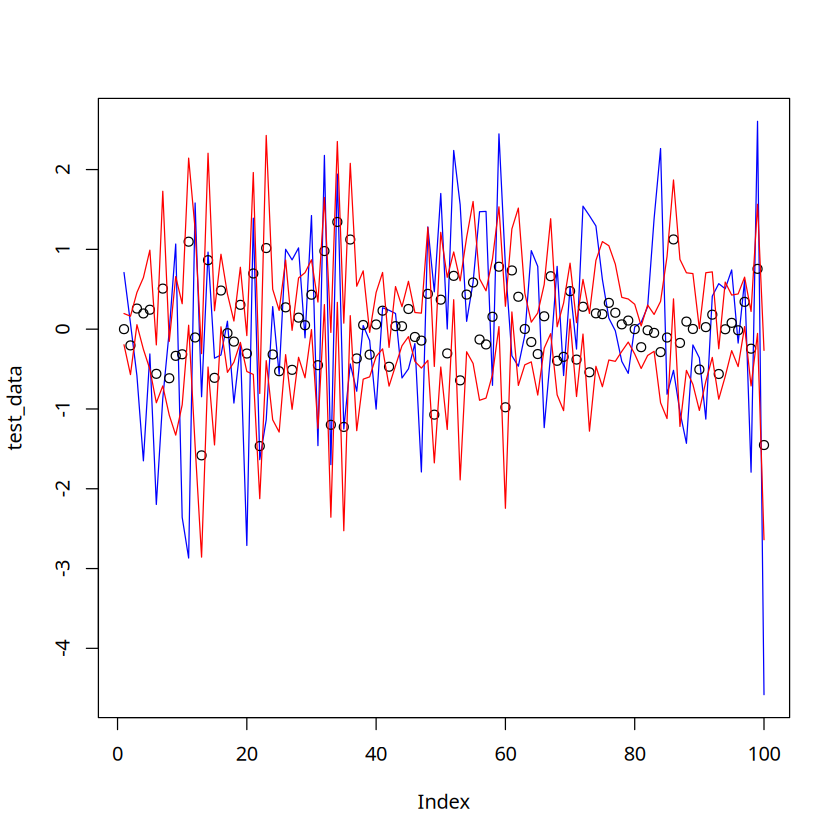

In [5]:
generate_forecast_plot(test_set, theta_est, A_est)

 # Data/IMOEX.csv

# Импорт

In [6]:
IMOEX <- read.csv2(file = "./Data/IMOEX.csv" , sep = ",")
IMOEX <- IMOEX[-6]

IMOEX <- data.frame(
  Дата = dmy(IMOEX$Дата), 
  Цена = as.numeric(gsub(",", ".", gsub("\\.", "", IMOEX$Цена))),
  Откр. = as.numeric(gsub(",", ".", gsub("\\.", "", IMOEX$Откр.))),
  Макс. = as.numeric(gsub(",", ".", gsub("\\.", "", IMOEX$Макс.))),
  Мин. = as.numeric(gsub(",", ".", gsub("\\.", "", IMOEX$Мин.))),
  Изм = as.numeric(gsub(",", ".", gsub("%", "", IMOEX$Изм))) / 100 
)

summary(IMOEX)
length(IMOEX$Цена)

      Дата                 Цена          Откр.          Макс.     
 Min.   :2020-01-17   Min.   :1917   Min.   :1784   Min.   :1918  
 1st Qu.:2021-01-28   1st Qu.:2474   1st Qu.:2474   1st Qu.:2512  
 Median :2022-02-01   Median :3026   Median :3018   Median :3051  
 Mean   :2022-02-15   Mean   :2992   Mean   :2994   Mean   :3016  
 3rd Qu.:2023-03-09   3rd Qu.:3424   3rd Qu.:3426   3rd Qu.:3461  
 Max.   :2024-03-15   Max.   :4288   Max.   :4285   Max.   :4293  
      Мин.           Изм            
 Min.   :1682   Min.   :-0.3328000  
 1st Qu.:2438   1st Qu.:-0.0054000  
 Median :2999   Median : 0.0012500  
 Mean   :2966   Mean   : 0.0002417  
 3rd Qu.:3391   3rd Qu.: 0.0072000  
 Max.   :4259   Max.   : 0.2004000  

[1] 1036

# График динамики актива

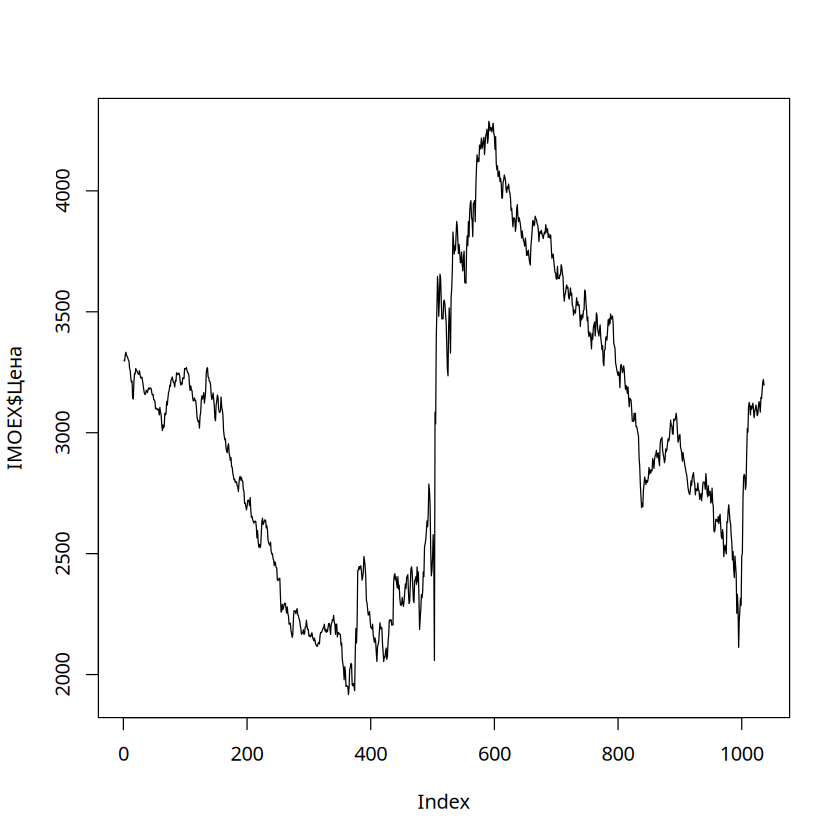

In [7]:
plot(IMOEX$Цена, type = "l")

# Стационарный вид

In [8]:
P_k <- IMOEX$Цена[-1]
P_k_1 <- IMOEX$Цена[-length(IMOEX$Цена)]
z <- log(P_k / P_k_1)


# График доходностей

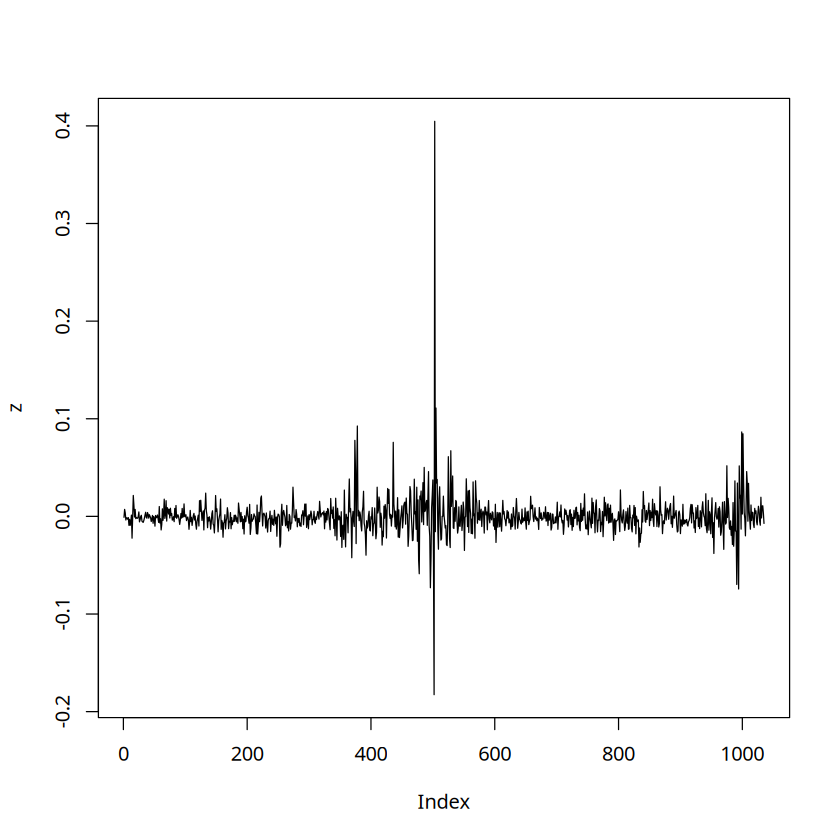

In [9]:
plot(z, type = "l")

# 𝐴𝑅(2)𝐴𝑅𝐶𝐻(3) Реальные данные


 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     8.621524e-06     1.000e+00
     2     5.000000e-02     1.000e+00
     3     5.000000e-02     1.000e+00
     4     5.000000e-02     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1 -5.418e+03
     1   10 -5.418e+03  8.73e-08  1.82e-07  1.2e-07  7.1e+12  1.2e-08  6.46e+05
     2   23 -5.418e+03 -1.95e-14  1.59e-16  5.1e-15  4.7e+05  5.1e-16  2.00e-07

 ***** FALSE CONVERGENCE *****

 FUNCTION    -5.418070e+03   RELDX        5.145e-15
 FUNC. EVALS      23         GRAD. EVALS       2
 PRELDF       1.586e-16      NPRELDF      1.996e-07

     I      FINAL X(I)        D(I)          G(I)

     1    8.609710e-06     1.000e+00     1.670e+03
     2    5.000000e-02     1.000e+00    -1.019e-02
     3    5.000000e-02     1.000e+00    -9.466e-03
     4    5.000000e-02     1.000e+00    -1.007e-02



Warning message in garch(h, order = c(3, 0)):
“singular information”


ar1         ar2 
-0.13238486  0.02676927

a0          b1          b2          b3 
8.60971e-06 5.00000e-02 5.00000e-02 5.00000e-02

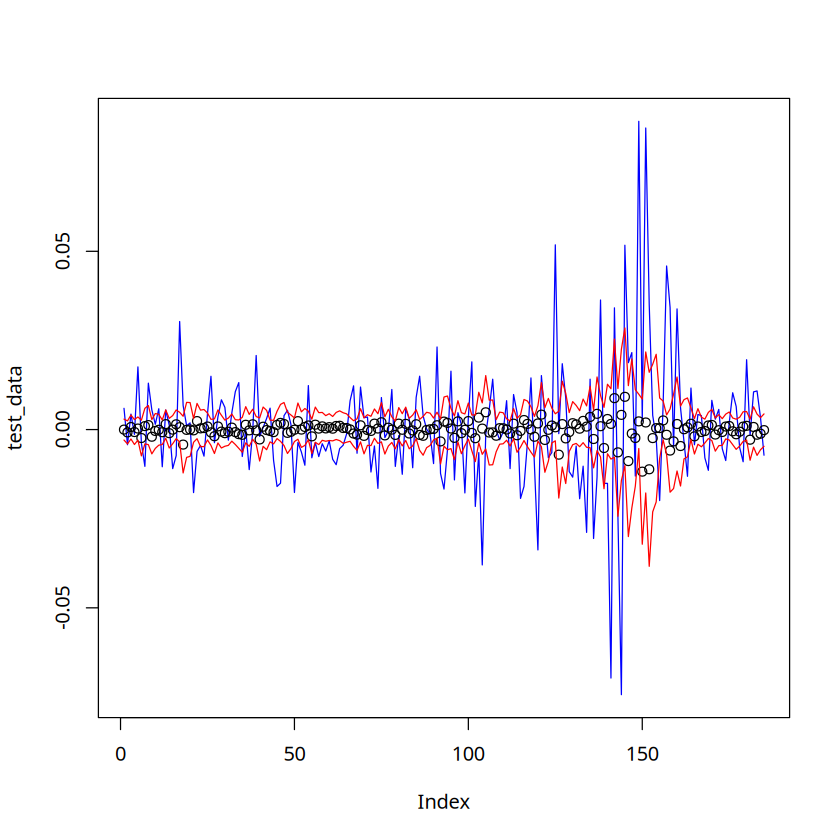

In [10]:
# 2
train_set <- z[1:850]
test_set <- z[851:length(z)]
# 3
arima_model <- arima(train_set, order = c(2, 0, 0), include.mean = FALSE)
theta_est <- arima_model$coef[1:2]

h <- numeric(length(z))
h[1:2] <- train_set[1:2]

for (i in 3:length(test_set)) {
  h[i] <- train_set[i] - theta_est[1] * train_set[i - 1] - theta_est[2] * train_set[i - 2]
}


garch_model <- garch(h, order = c(3, 0))

A_est <- c(garch_model$coef[1], garch_model$coef[2], garch_model$coef[3], garch_model$coef[4])

theta_est
A_est
# 4
generate_forecast_plot(test_set, theta_est, A_est)